In [3]:
# plan data
# load arrs, pgv4 new
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
import os

def load_large_outputs(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/large_outputs/' # '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'outer_loop_pg_new_v4f_test_02_11-183526.pkl' # 'outer_loop_pg_new_v4f_02_11-010356.pkl' # 'outer_loop_pg_new_v4f_test_01_11-135408.pkl' # 'outer_loop_pg_new_v4f_test_01_11-135016.pkl' # 'outer_loop_pg_new_v4f_test_31_10-211852.pkl'
other = load_large_outputs(file_)

## if not test:
# (selected_other,plan_info) = other
# (r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr,hs_arr,hv_arr,vec_ind_arr,act_ind_arr),_ = selected_other
# plan:
# (r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr,hs_arr,hv_arr,vec_ind_arr,act_ind_arr),_ = plan_info['other_']

# if test:
(r_arr,rp_arr,sample_arr,mask_arr,pos_plan_arr,pos_arr,dot_arr,policy_arr,hs_arr,hv_arr,vec_ind_arr,act_ind_arr) = other
print('r_arr.shape=',r_arr.shape,'rp_arr.shape=',rp_arr.shape,'sample_arr.shape=',sample_arr.shape,'mask_arr.shape=',mask_arr.shape,'\n','pos_plan_arr.shape=',pos_plan_arr.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'policy_arr.shape=',policy_arr[0].shape,'\n','hs_arr=',hs_arr.shape,'hv_arr=',hv_arr.shape)
print('r_tot=',np.mean(np.sum(r_arr,axis=1)))
print('plan_rate=',np.sum(sample_arr,axis=None)/np.sum(mask_arr,axis=None))

r_arr.shape= (1000, 60) rp_arr.shape= (1000, 60) sample_arr.shape= (1000, 60) mask_arr.shape= (1000, 60) 
 pos_plan_arr.shape= (1000, 61, 2) pos_arr.shape= (1000, 61, 2) dot_arr.shape= (1000, 61, 2) policy_arr.shape= (1000, 60, 81) 
 hs_arr= (1000, 60, 100) hv_arr= (1000, 60, 300)
r_tot= 6.663068
plan_rate= 0.12925918


In [ ]:
# noplan data
# load arrs, pgv4 new 
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
import os

def load_large_outputs(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/large_outputs/' # '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'outer_loop_pg_new_v4f_test_02_11-183559.pkl' # 'outer_loop_pg_new_v4f_test_01_11-135335.pkl' # 'outer_loop_pg_new_v4f_test_01_11-135116.pkl' # 'outer_loop_pg_new_v4f_test_31_10-211936.pkl'
other = load_large_outputs(file_)
(r_arr_np,rp_arr_np,sample_arr_np,mask_arr_np,pos_plan_arr_np,pos_arr_np,dot_arr_np,policy_arr_np,hs_arr_np,hv_arr_np,vec_ind_arr_np,act_ind_arr_np) = other
sample_arr_np = jnp.zeros_like(sample_arr_np)
print('r_arr.shape=',r_arr_np.shape,'rp_arr.shape=',rp_arr_np.shape,'sample_arr.shape=',sample_arr_np.shape,'mask_arr.shape=',mask_arr_np.shape,'\n','pos_plan_arr.shape=',pos_plan_arr_np.shape,'pos_arr.shape=',pos_arr_np.shape,'dot_arr.shape=',dot_arr_np.shape,'policy_arr.shape=',policy_arr_np[0].shape,'\n','hs_arr=',hs_arr_np.shape,'hv_arr=',hv_arr_np.shape)
print('r_tot=',np.mean(np.sum(r_arr_np,axis=1)))
print('plan_rate=',np.sum(sample_arr_np,axis=None)/np.sum(mask_arr_np,axis=None))

In [82]:
def compute_dot_speed(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    speed = np.linalg.norm(dot_diffs, axis=2)
    mean_speed = np.mean(speed, axis=1)
    return mean_speed

def compute_dot_direction(dot_arr):
    dot_diffs = np.diff(dot_arr, axis=1)
    mean_dot_dir = np.mean(dot_diffs, axis=1)
    norm_dot_dir = np.linalg.norm(mean_dot_dir, axis=1)
    mean_dot_dir_normalized = mean_dot_dir / norm_dot_dir[:, np.newaxis]
    return mean_dot_dir_normalized

def generate_speed_bins(N, speeds):
    min_speed, max_speed = np.min(speeds), np.max(speeds)
    bins = np.linspace(min_speed, max_speed, N + 1)
    return bins

def generate_bin_vectors(N):
    angles = np.linspace(0, 2 * np.pi, N+1)[:-1]  # Avoiding overlap with 0
    return np.column_stack((np.cos(angles), np.sin(angles)))

def bin_trials_by_speed_and_direction(dot_arr, N_speed, N_direction):
    speeds = compute_dot_speed(dot_arr)
    directions = compute_dot_direction(dot_arr)

    speed_bins = generate_speed_bins(N_speed, speeds)
    direction_bins = generate_bin_vectors(N_direction)

    bins = np.zeros((N_speed, N_direction), dtype=object)
    for i in range(N_speed):
        for j in range(N_direction):
            in_speed_bin = (speeds >= speed_bins[i]) & (speeds < speed_bins[i + 1])
            direction_similarity = directions @ direction_bins[j]
            in_direction_bin = direction_similarity > np.cos(np.pi / N_direction)

            # Indices of trials in both speed and direction bins
            bins[i, j] = np.where(in_speed_bin & in_direction_bin)[0]

    return bins

sbins = 3 # 8
abins = 4 # 8

bins = bin_trials_by_speed_and_direction(dot_arr, sbins, abins)

# print(bins[0][0])

In [83]:
# form matrix of trial-averaged data X[n,t,a,d] (consider with conditional probability analogy)
# objective: X[Ns,T,N] -> X[N,T,A,S]

# reshape, center data X[Ns,T,N] -> X[Ns*T,N]
def bin_trials_by_speed_and_direction(dot_arr, N_speed, N_direction):
    speeds = compute_dot_speed(dot_arr)
    directions = compute_dot_direction(dot_arr)

    speed_bins = generate_speed_bins(N_speed, speeds)
    direction_bins = generate_bin_vectors(N_direction)

    bins = np.zeros((N_speed, N_direction), dtype=object)
    for i in range(N_speed):
        for j in range(N_direction):
            in_speed_bin = (speeds >= speed_bins[i]) & (speeds < speed_bins[i + 1])
            direction_similarity = directions @ direction_bins[j]
            in_direction_bin = direction_similarity > np.cos(np.pi / N_direction)
            bins[i, j] = np.where(in_speed_bin & in_direction_bin)[0]

    return bins

def reshape_center(arr):
    Ns,T,N = arr.shape
    arr_reshaped = arr.reshape(-1, N)
    reshaped_centered_arr = arr_reshaped - arr_reshaped.mean(axis=0)
    return reshaped_centered_arr

def marginal_average_t_given_s_a(s,a,trials,neuron_index,data,T, speed_labels, angle_labels):
    if len(trials) == 0:
        print(f'no trials in bin s={s}, a={a}')
        return np.zeros(T)
    Ns = data.shape[0] // T

    marginal_sums = np.zeros(T)
    for trial in trials:
        trial_data = data[trial * T : (trial + 1) * T, neuron_index]
        marginal_sums += trial_data
        assert np.isnan(speed_labels[trial]) or speed_labels[trial] == s, f'speed label {speed_labels[trial]} != {s}'
        assert np.isnan(angle_labels[trial]) or angle_labels[trial] == a, f'angle label {angle_labels[trial]} != {a}'
        speed_labels[trial] = np.int32(s)
        angle_labels[trial] = np.int32(a)
    marginal_average_t = marginal_sums / len(trials)


    return marginal_average_t, speed_labels, angle_labels

def compute_marginals(bins, arr, abins, sbins, Ns, T, N):
    hs_arr_reshaped = reshape_center(arr)

    X_marginals = np.full((N, T, abins, sbins), np.nan)
    X_trial_array = np.full((Ns, N, T, abins, sbins), np.nan)
    speed_labels = np.full((Ns), np.nan)
    angle_labels = np.full((Ns), np.nan)
    for n in range(N):
        for s in range(sbins):
            for a in range(abins):
                trials = bins[s, a]
                X_marginals[n, :, a, s], speed_labels, angle_labels = marginal_average_t_given_s_a(s,a,trials, n, hs_arr_reshaped, T, speed_labels, angle_labels)
    
    for i in range(Ns):
        angle_bin = np.int32(angle_labels[i])
        speed_bin = np.int32(speed_labels[i])
        for n in range(N):
            # print('i',type(i),'n',type(n),'angle_bin',type(angle_bin),'speed_bin',type(speed_bin))
            X_trial_array[i, n, :, angle_bin, speed_bin] = arr[i, :, n]
    return X_marginals, X_trial_array, speed_labels, angle_labels

# label all trials with (t,a,s) information
Ns,T,N = hs_arr.shape
sbins = 3
abins = 4 # 8

hs_arr_reshaped = reshape_center(hs_arr)

bins_s_a = bin_trials_by_speed_and_direction(dot_arr, sbins, abins)
print('bin shape=',bins_s_a.shape)
X_marginal_hs, X_trial_array_hs, speed_labels, angle_labels = compute_marginals(bins_s_a, hs_arr, abins, sbins, Ns, T, N)

print(X_marginal_hs.shape)
print(X_trial_array_hs.shape)

bin shape= (3, 4)


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_37473/781209521.py:61: RuntimeWarning: invalid value encountered in cast
  angle_bin = np.int32(angle_labels[i])
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_37473/781209521.py:62: RuntimeWarning: invalid value encountered in cast
  speed_bin = np.int32(speed_labels[i])


(100, 60, 4, 3)
(1000, 100, 60, 4, 3)


In [ ]:
# check for nans......

In [84]:
# verify marginal array

def verify_marginals(data, bins, T, N, X_marginal):
    # Go through each neuron
    for n in range(N):
        # Go through each angle and stimulus combination
        for a in range(abins):
            for s in range(sbins):
                trials = bins[s][a]
                
                # Skip if there are no trials for this bin
                if len(trials) == 0:
                    continue
                
                # Compute the manual marginal average for this bin
                marginal_sums = np.zeros(T)
                for trial in trials:
                    trial_data = data[trial * T : (trial + 1) * T, n]
                    marginal_sums += trial_data
                manual_marginal_average_t = marginal_sums / len(trials)
                
                # Fetch the marginal from the computed array
                computed_marginal = X_marginal[n, :, a, s]
                
                # Compare the two
                if not np.allclose(manual_marginal_average_t, computed_marginal):
                    print(f"Discrepancy found for neuron {n}, angle {a}, stimulus {s}")
                    return False
    
    # If no discrepancies were found
    print("All verifications passed.")
    return True

verify_marginals(hs_arr_reshaped, bins_s_a, T, N, X_marginal_hs)


All verifications passed.


True

In [85]:
# instantiate dPCA model with labelled parameter axes
# %pylab inline
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

# dpca = dPCA.dPCA(n_components=np.int32(2))
# dpca.fit(X_marginal_hs)

dpca = dPCA.dPCA(labels='dst',regularizer='auto',n_components=5) # cant use 'tas' bc of string parsing errors
# dpca = dPCA.dPCA(labels='tas',join={'tas' : ['t','a','s']},regularizer='auto')
# dpca = dPCA.dPCA(labels=3,regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [86]:
# perform dPCA using automatical regularization determination

# %pylab inline
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

X_marginal_hs_reshaped = X_marginal_hs.transpose(0, 2, 3, 1)
X_trial_array_hs_reshaped = X_trial_array_hs.transpose(0, 1, 3, 4, 2)

X_marginal_hs_reshaped = numpy.nan_to_num(X_marginal_hs_reshaped, nan=0.0)
X_trial_array_hs_reshaped = numpy.nan_to_num(X_trial_array_hs_reshaped, nan=0.0)

Z = dpca.fit_transform(X_marginal_hs_reshaped,trialX=X_trial_array_hs_reshaped)

# n_comp=10, optimal_lambda = 0.004743480741674971
# n_comp=5, optimal lambda = 0.006640873038344959

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.006640873038344959
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [87]:
print('Z.keys()=',Z.keys())

print('Z["d"].shape=',Z['d'].shape)
print('Z["s"].shape=',Z['s'].shape)
print('Z["t"].shape=',Z['t'].shape)
print('Z["ds"].shape=',Z['ds'].shape)


Z.keys()= dict_keys(['d', 's', 't', 'ds', 'dt', 'st', 'dst'])
Z["d"].shape= (5, 4, 3, 60)
Z["s"].shape= (5, 4, 3, 60)
Z["t"].shape= (5, 4, 3, 60)
Z["ds"].shape= (5, 4, 3, 60)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/lukej/Documents/meta_rl_ego_sim/venv3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


ValueError: x and y must have same first dimension, but have shapes (60,) and (8, 3)

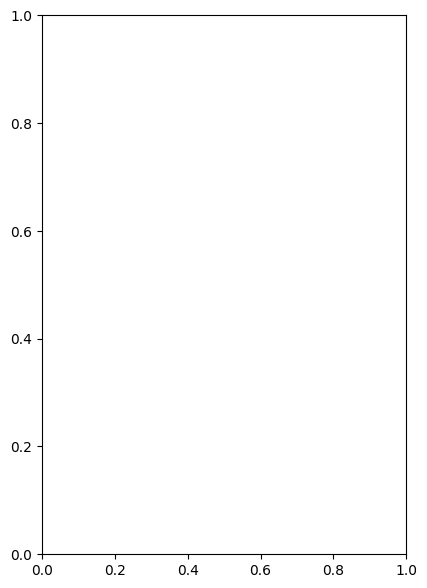

In [76]:
# plot dPCA results

%pylab inline
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

time = arange(T)

figure(figsize=(16,7))
subplot(131)

# adjust to be 3d plots - plot trajectories of each component ['d','s','ds', etc] across time with colormap
# currently 2d plot of top component across time for diff stimuli settings, where data is [PCs,stim,time]

for s in range(sbins):
    plt.plot(time,Z['d'][0,:,:,:]) # plt.plot(time,Z['d'][0,s,:])

title('1st direction component')
    
subplot(132)

for s in range(sbins):
    plot(time,Z['s'][0,:,:,:])
    
title('1st stimulus component')
    
subplot(133)

for s in range(sbins):
    plot(time,Z['ds'][0,:,:,:])
    
title('1st d/s mixing component')
show()

In [93]:
# plot varying speed bin in colour
# 3d space where x=time, y=firing rate, z=direction bin

# %matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'data' is your (10,8,3,60) numpy array
data = X_marginal_hs_reshaped

# We will plot the first component, so we select it
first_component = data[0]  # This will have shape (8,3,60)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Time points
time = np.arange(T)

# Speed is represented by different colors
colors = ['r', 'g', 'b']  # Let's say red, green, blue for the three different speeds

# Plot each line with a different color
for i in range(first_component.shape[1]):  # Iterate over the 'speed' dimension (3)
    for j in range(first_component.shape[0]):  # Iterate over the 'direction' dimension (8)
        # Plotting the line with time on x-axis, 'directions' as y and the values as z
        ax.plot(time, np.full_like(time, j), first_component[j, i, :], color=colors[i])

# Set the labels for the axes
ax.set_xlabel('Time')
ax.set_ylabel('Direction')
ax.set_zlabel('Output')

# Optionally, set the range for y-axis if you want specific ticks for 'direction'
ax.set_yticks(range(first_component.shape[0]))

# Show the plot
plt.show()

<IPython.core.display.Javascript object>